In [27]:
%matplotlib inline

import glob
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import imageio as im
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from keras import callbacks
import keras.initializers
import csv
from PIL import Image
import tensorflow as tf
import pathlib
import os

In [2]:
# Read train.csv
imageData = []
with open('./train.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')

    for row in csv_reader:
        imageData.append(row)

In [3]:
# Extract the different species
species = []
for i in range(1, len(imageData)):
    if imageData[i][1] not in species:
        species.append(imageData[i][1])


30


In [4]:
# Create a label dict for species
speciesDict = {}
for i in range(len(species)):
    speciesDict[species[i]] = i
    

In [5]:
# Create a label dict for image and species
imageSpeciesDict = {}
for i in range(len(imageData)):
    imageSpeciesDict[imageData[i][0]] = imageData[i][1]
    


## Gather Train/Validation/Test Images with Labels

In [63]:
# Importing images with labels
# train_images = pathlib.Path('/home/sean/.keras/datasets/organized_train_images')
train_images = pathlib.Path('/home/sean/.keras/datasets/organized_train2_images')
validation_images = pathlib.Path('/home/sean/.keras/datasets/organized_validation_images')
test_images = pathlib.Path('/home/sean/.keras/datasets/organized_test_images')


train_list_ds = tf.data.Dataset.list_files(str(train_images/'*/*'))
validation_list_ds = tf.data.Dataset.list_files(str(validation_images/'*/*'))
test_list_ds = tf.data.Dataset.list_files(str(test_images/'*/*'))

def process_path(file_path):
    parts = tf.strings.split(file_path, os.sep)
    label = int(parts[-2])
    
    image = tf.io.read_file(file_path)
    image = tf.io.decode_jpeg(image,channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [64, 64])
    image = tf.reshape(image, [64, 64, 3])
    return image, label


train_labeled_ds = train_list_ds.map(process_path)
validation_labeled_ds = validation_list_ds.map(process_path)
test_labeled_ds = test_list_ds.map(process_path)

print(train_labeled_ds)
print(validation_labeled_ds)
print(test_labeled_ds)

# for image_raw, label_text in train_labeled_ds.take(1):
#     print(image_raw)
#     print()
#     print(label_text.numpy())


<MapDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
<MapDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
<MapDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>


## Gathering Test Images without Labels

In [42]:
# Importing test images from test_images that don't have labels
test_images = pathlib.Path('/home/sean/.keras/datasets/test_images')


test_images_list_ds = tf.data.Dataset.list_files(str(test_images/'*'))

def process_path(file_path):
    image = tf.io.read_file(file_path)
    image = tf.io.decode_jpeg(image,channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [64, 64])
    image = tf.reshape(image, [64, 64, 3])
    return image

test_ds = test_images_list_ds.map(process_path)

print(test_ds)
# for image_raw in test_ds.take(1):
#     print(repr(image_raw.numpy()[:100]))

<MapDataset element_spec=TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None)>


## Image Parsing

In [94]:
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.
def parse_image(filename):
    parts = tf.strings.split(filename, os.sep)
    label = parts[-2]

    image = tf.io.read_file(filename)
    image = tf.io.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

    image = tf.image.convert_image_dtype(image, tf.float32)

    return image



## Showing an Image

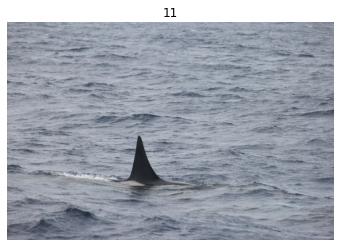

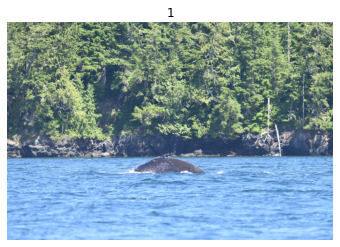

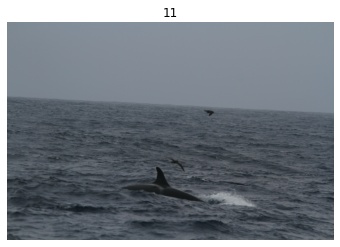

In [96]:
# Show an image
file_path = next(iter(train_list_ds))
image1, label1 = parse_image(file_path)

file_path = next(iter(validation_list_ds))
image2, label2 = parse_image(file_path)

file_path = next(iter(test_list_ds))
image3, label3 = parse_image(file_path)

def show(image, label):
    plt.figure()
    plt.imshow(image)
    plt.title(label.numpy().decode('utf-8'))
    plt.axis('off')

show(image1, label1)
show(image2, label2)
show(image3, label3)


## Batching Train/Validation/Test Data

In [89]:
# # batching
# batched_train_ds = train_labeled_ds.batch(16)
# batched_validation_ds = validation_labeled_ds.batch(16)
# batched_test_ds = test_labeled_ds.batch(16)

# # batching
# batched_train_ds = train_labeled_ds.batch(50)
# batched_validation_ds = validation_labeled_ds.batch(50)
# batched_test_ds = test_labeled_ds.batch(50)

# batching
batched_train_ds = train_labeled_ds.batch(100)
batched_validation_ds = validation_labeled_ds.batch(100)
batched_test_ds = test_labeled_ds.batch(100)

print(batched_train_ds)
print(batched_validation_ds)
print(batched_test_ds)

<BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


## Build CNN Model

In [87]:
# define the CNN model
def cnn_model():
#     # Attempt1
#     model = Sequential()
#     model.add(Conv2D(32, (3, 3), padding='same', input_shape = (64, 64, 3), 
#                      activation = 'relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(Dropout(0.5)) # antes era 0.25
    
#     model.add(Flatten())
#     model.add(Dense(64, activation='relu'))
#     model.add(Dense(30))
    
#     model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])


    # Attempt2
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', 
                     input_shape = (64, 64, 3), 
                     activation = 'relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5)) 

    # Adding a second convolutional layer
    model.add(Conv2D(64, (3, 3), padding='same', 
                     activation = 'relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5)) 

    # Adding a third convolutional layer
    model.add(Conv2D(64, (3, 3), padding='same', 
                     activation = 'relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5)) 

    # Step 3 - Flattening
    model.add(Flatten())

    # Step 4 - Full connection
    model.add(Dense(units = 512, activation = 'relu'))
    model.add(Dropout(0.5)) 
    model.add(Dense(units = 30, activation = 'softmax'))

    # Compile model
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer='adam', metrics=['accuracy'])
    
    
    return model

## Train

In [90]:
%%time

print(batched_train_ds)
print(batched_test_ds)

earlystopping = callbacks.EarlyStopping(
    monitor ="val_loss", 
    mode ="min", patience = 5, 
    restore_best_weights = True)

np.random.seed(0)
# build the model
model_cnn = cnn_model()
# Check out the layers in our model
model_cnn.summary()
# Fit the model
history = model_cnn.fit(batched_train_ds, validation_data=batched_validation_ds, epochs=25, 
                        callbacks =[earlystopping])

<BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_135 (Conv2D)         (None, 64, 64, 32)        896       
                                                                 
 conv2d_136 (Conv2D)         (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_71 (MaxPoolin  (None, 31, 31, 64)       0         
 g2D)                                                            
                                                                 
 dropout_71 (Dropout)        (None, 31, 31, 64)        0         
                   

## Evaluate

In [91]:
scores = model_cnn.evaluate(
    batched_test_ds, 
    verbose=1)
print('Final CNN accuracy: ', scores[1])

77/77 [==============================] - 123s 2s/step - loss: 0.5477 - accuracy: 0.8350
Final CNN accuracy:  0.8350098133087158


## Plot Results

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


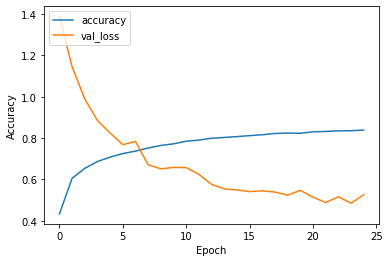

In [92]:
print(history.history.keys())
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0, 1])
plt.legend(loc='upper left')

plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0, 1])
plt.legend(loc='upper left')